# Multi-Class Prediction of Obesity Risk

**Programa de Engenharia de Sistemas e Computação**

**CPS833 - Data Mining**

**Professor**: Geraldo Zimbrão da Silva

**Aluno**: Luiz Henrique Souza Caldas

## Importação de bibliotecas

In [79]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from yellowbrick.target import FeatureCorrelation
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

## Análise Exploratória dos Dados e Pré-processamento

### Importação dos dados

Carregamento dos datasets de treinamento e de teste.

In [80]:
train_dataset = pd.read_csv('train.csv')
test_dataset = pd.read_csv('test.csv')

### Exploração inicial

Análise inicial dos dados para entender sua estrutura, dimensões e características básicas.

In [3]:
print(f"Dataset de treinamento {train_dataset.shape}")
print(f"Dataset de teste {test_dataset.shape}")
cols_categoricas = train_dataset.select_dtypes(include=['object']).nunique()
print(f'{cols_categoricas.shape[0]} colunas de dados categóricos ({cols_categoricas.shape[0]-1} features + label)')
num_binarias = cols_categoricas[cols_categoricas == 2].shape[0]
print(f"{num_binarias} features binárias")
num_classes = cols_categoricas["NObeyesdad"]
print(f'{num_classes} classes diferentes \n')
print(cols_categoricas)
train_dataset.head()

Dataset de treinamento (20758, 18)
Dataset de teste (13840, 17)
9 colunas de dados categóricos (8 features + label)
5 features binárias
7 classes diferentes 

Gender                            2
family_history_with_overweight    2
FAVC                              2
CAEC                              4
SMOKE                             2
SCC                               2
CALC                              3
MTRANS                            5
NObeyesdad                        7
dtype: int64


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


Excluindo a coluna id, os dois datasets possuem 16 features, sendo 08 features categóricas (05 binárias do tipo "sim" ou "não"). Apenas o dataset de treinamento possui a coluna de labels ("NObeyesdad"), sendo que essa também é categórica. O dataset de treinamento possui 20758 amostras para treinar o classificador, enquanto o dataset de teste possui 13840 amostras a serem classificadas. O problema de classificação possui 7 classes diferentes.

### Limpeza dos dados

Tratamento de dados ausentes, duplicados ou inconsistentes para garantir a qualidade dos dados.

0 dados faltantes no dataset de treino
0 dados faltantes no dataset de teste
0 linhas duplicadas no dataset de treino


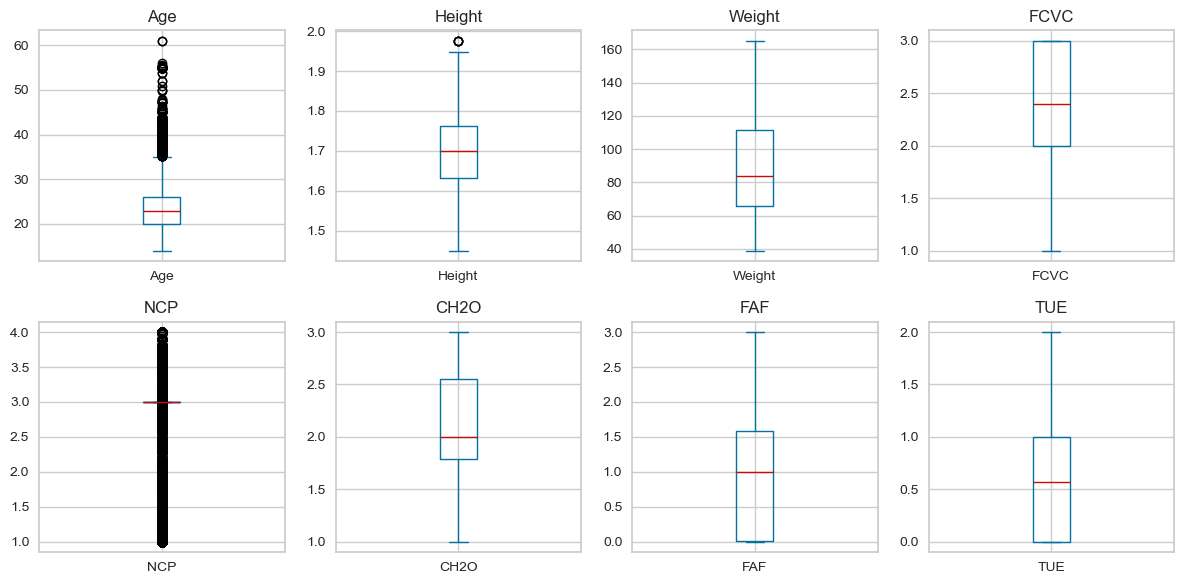

In [4]:
# Verificação de dados ausentes
print(f"{train_dataset.isnull().any().sum()} dados faltantes no dataset de treino")
print(f"{test_dataset.isnull().any().sum()} dados faltantes no dataset de teste")

# Verificação de linhas duplicadas
print(f"{train_dataset.duplicated().sum()} linhas duplicadas no dataset de treino")

# Verificação de outliers
colunas_numericas = train_dataset.iloc[:,1:].select_dtypes(include=['number']).columns.tolist()
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
for i, coluna in enumerate(colunas_numericas):
    row = i // 4
    col = i % 4
    train_dataset[coluna].plot(kind='box', ax=axs[row, col])
    axs[row, col].set_title(f'{coluna}')
plt.tight_layout()
plt.show()

Nenhum dos dois datasets possui dados faltantes. A verificação de linhas duplicadas foi feita apenas no dataset de treinamento, pois mesmo que houvesssem linhas duplicadas no dataset de treino isso não importaria para a classificação delas, diferente do dataset de treinamento, no qual as linhas duplicadas poderiam inserir um viés. Além disso, foram plotados os boxplots para cada coluna numérica. Pelo critério de $1,5 \times IQR$ (Intervalo Interquartil), foram verificados outliers nas features idade, altura e NCP. Na coluna idade, por ter poucos indivíduos dessa faixa etária no dataset, todas as idades acima de 35 anos foram consideradas outliers. Na coluna altura, apenas um indivíduo de altura de quase 2 metros foi considerado outlier. Na coluna NCP a maior parte dos dados se concentrou por volta do valor 3, o que fez com que todos os dados afastados desse valor fossem considerados outliers. Como nenhum dos dados dessas três colunas pareceu realmente ser um outlier, nenhum indivíduo foi removido. 

### Análise estatística descritiva

Calculo das estatísticas descritivas como média, mediana, desvio padrão, mínimo, máximo e quartis, para entender a distribuição dos dados e identificar possíveis anomalias. 

                Age        Height        Weight          FCVC           NCP  \
count  20758.000000  20758.000000  20758.000000  20758.000000  20758.000000   
mean      23.841804      1.700245     87.887768      2.445908      2.761332   
std        5.688072      0.087312     26.379443      0.533218      0.705375   
min       14.000000      1.450000     39.000000      1.000000      1.000000   
25%       20.000000      1.631856     66.000000      2.000000      3.000000   
50%       22.815416      1.700000     84.064875      2.393837      3.000000   
75%       26.000000      1.762887    111.600553      3.000000      3.000000   
max       61.000000      1.975663    165.057269      3.000000      4.000000   

               CH2O           FAF           TUE  
count  20758.000000  20758.000000  20758.000000  
mean       2.029418      0.981747      0.616756  
std        0.608467      0.838302      0.602113  
min        1.000000      0.000000      0.000000  
25%        1.792022      0.008013     

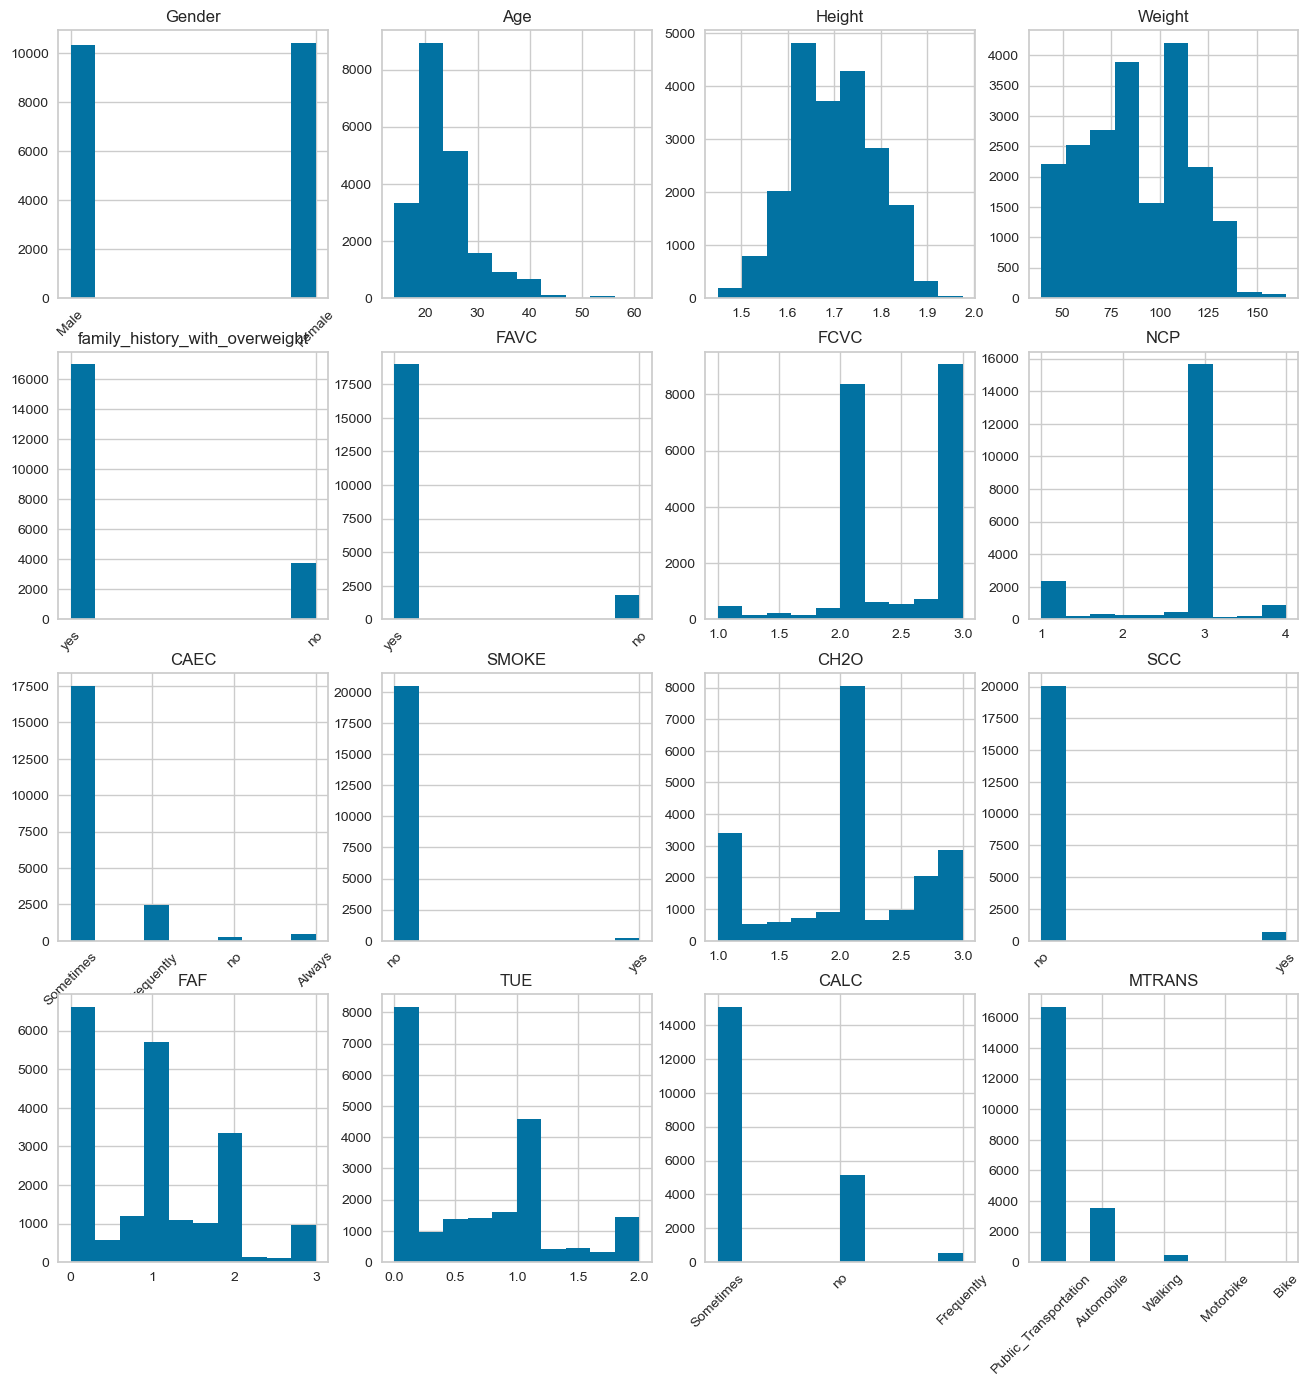

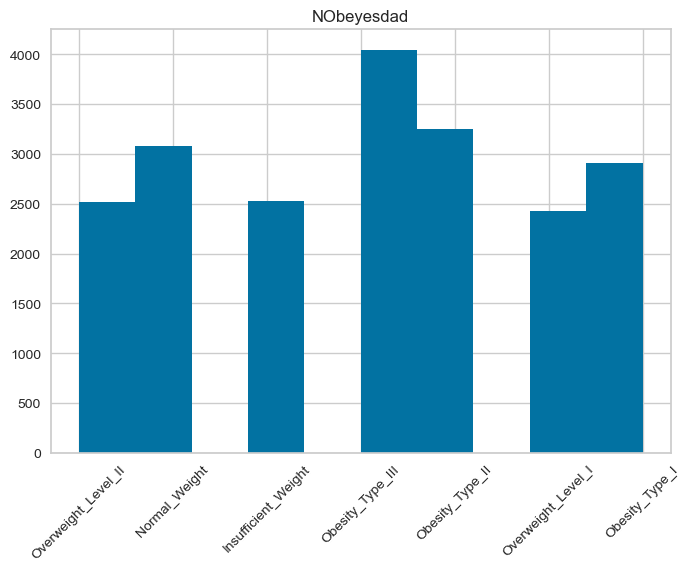

In [5]:
print(train_dataset.iloc[:,1:].describe())

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

# Iterar sobre as colunas do DataFrame e plotar histograma em cada subplot
for i, coluna in enumerate(train_dataset.iloc[:,1:-1].columns):
    row = i // 4
    col = i % 4
    axs[row, col].hist(train_dataset[coluna], bins=10)
    axs[row, col].set_title(coluna)
    if test_dataset[coluna].dtype == 'object':
        axs[row, col].set_xticks(train_dataset[coluna].unique())
        axs[row, col].set_xticklabels(train_dataset[coluna].unique(), rotation=45)
plt.show();

plt.figure()
train_dataset["NObeyesdad"].hist()
plt.title("NObeyesdad")
plt.xticks(rotation=45)
plt.show();

As principais conclusões que podem ser retiradas dessa análise já foram verificadas na plotagem do boxplot.  
* Metade dos indivíduos da amostra estão na faixa etária entre 20 e 26 anos, o que indica que os dados de treinamento possuem um viés para indivíduos mais jovens.
* O valor máximo do atributo altura ($1,97m$) foi o único considerado como outlier pelo critério de $1,5 \times IQR$.
* A feature NCP possui o mesmo valor para os 3 quartis, o que indica uma alta concentração dos dados em $NCP = 3$.

Além disso foi verificado também que as classes estão razoavelmente balanceadas.

### Codificação de dados categóricos
Atribuição de valores numéricos para os dados categóricos utilizando o Label Encoder do scikit-learn. Apenas o mapeamento dos labels foi feito de forma manual com o objetivo de manter a ordem das categorias.


In [128]:
label_encoder = LabelEncoder()

train_dataset_encoded = train_dataset.copy()  # Faz uma cópia do dataset de treino para evitar alterações no original
mapeamento = {
    "Insufficient_Weight": 0,
    "Normal_Weight": 1,
    "Overweight_Level_I": 2,
    "Overweight_Level_II": 3,
    "Obesity_Type_I": 4,
    "Obesity_Type_II": 5,
    "Obesity_Type_III": 6
}
train_dataset_encoded["NObeyesdad"] = train_dataset["NObeyesdad"].map(mapeamento) # mapeamento manual dos labels para manter a ordem
for col in train_dataset.columns:
    if train_dataset[col].dtype == 'object':  # Verifica se a coluna é categórica
        train_dataset_encoded[col] = label_encoder.fit_transform(train_dataset[col])

test_dataset_encoded = test_dataset.copy() # Faz uma cópia do dataset de teste para evitar alterações no original
for col in test_dataset.columns:
    if test_dataset[col].dtype == 'object':  # Verifica se a coluna é categórica
        test_dataset_encoded[col] = label_encoder.fit_transform(test_dataset[col])

### Normalização dos dados
Normalização dos dados para garantir que todas as variáveis tenham a mesma escala uzando a técnica z-score, que subtrai a média e divide pelo desvio padrão.

In [148]:
scaler = StandardScaler()
cols_to_normalize = train_dataset_encoded.columns.difference(['id','NObeyesdad']) # deixa de fora a id e os labels
train_dataset_encoded[cols_to_normalize] = scaler.fit_transform(train_dataset_encoded[cols_to_normalize])
cols_to_normalize = test_dataset_encoded.columns.difference(['id','NObeyesdad']) # deixa de fora a id
test_dataset_encoded[cols_to_normalize] = scaler.fit_transform(test_dataset_encoded[cols_to_normalize])

### Análise de correlação
#### Verificação da correlação de Pearson 2 a 2 entre os atributos do dataset de treinamento.

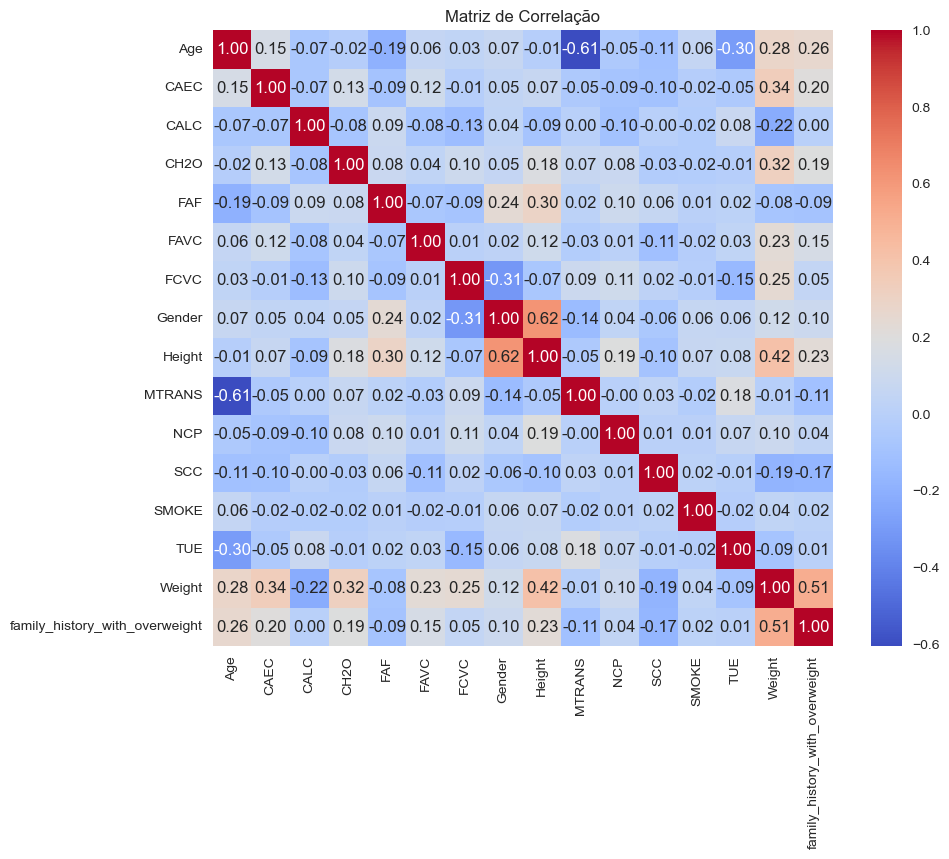

In [151]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_dataset_encoded[train_dataset_encoded.columns.difference(['id','NObeyesdad'])].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show();

Nesta análise de correlação foram deixadas de fora as colunas "id" (que é irrelevante) e "NObeyesdad" que será analisada mais adiante. Nenhuma correlação foi considerada forte o suficiente para justificar a remoção de uma feature e diminuir a dimensionalidade do dataset.

#### Verificação da correlação de Pearson entre as features e os labels no dataset de treinamento.

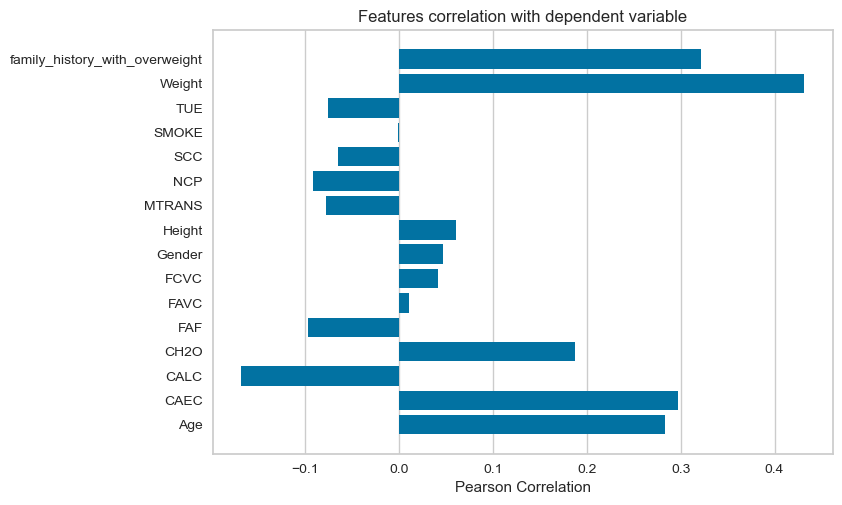

In [152]:
grafico = FeatureCorrelation(labels=train_dataset_encoded.columns.difference(['id','NObeyesdad']))
grafico.fit(train_dataset_encoded[train_dataset_encoded.columns.difference(['id','NObeyesdad'])].values, train_dataset_encoded["NObeyesdad"].values)
grafico.show();

As features "SMOKE" e "FAVC" aparentemente possuem uma correlação baixa com a classe. No entanto, ao remover essas features do dataset e realizar testes, os resultados obtidos foram significativamente piores em comparação com os testes que incluíram essas features. Isso sugere que, quando combinadas com outros atributos, "SMOKE" e "FAVC" podem ter uma correlação significativa com a classe. Por essa razão, optou-se por mantê-las no dataset.

### Separação das features e labels




In [153]:
features = train_dataset_encoded[train_dataset_encoded.columns.difference(['id','NObeyesdad'])].values # features do dataset de treino removendo o id
labels = train_dataset_encoded['NObeyesdad'].values # labels
test = test_dataset_encoded.drop(columns=['id']).values # removendo o id do dataset de teste

## Seleção de Modelo
### Escolha da técnica

Foram avaliadas as técnicas Naïve Beyes, Regressão Logística, Randon Forest, K-Nearest Neighbors (k-NN), e Support Vector Machine (SVM) utilizando as configurações padrão da biblioteca sklearn. O único parâmetro que foi alterado para além do padrão foi o número máximo de iterações da Regrassão Logística, pois no valor 200 que é o padrão o programa estava exibindo mensagens de que havia atingido o valor máximo de iterações.

In [16]:
resultados_naive_bayes = []
resultados_logistica = []
resultados_forest = []
resultados_knn = []
resultados_svm = []

for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    
    naive_bayes = GaussianNB() # criação do modelo Naive Bayes
    scores = cross_val_score(naive_bayes, features, labels, cv=kfold) # validação cruzada do modelo Naive Bayes
    resultados_naive_bayes.append(scores.mean()) # avaliação do modelo Naive Bayes
    
    logistica = LogisticRegression(max_iter=300) # criação do modelo de Regressão Logística
    scores = cross_val_score(logistica, features, labels, cv=kfold) # treinamento do modelo de Regressão Logística
    resultados_logistica.append(scores.mean()) # avaliação do modelo de Regressão Logística

    random_forest = RandomForestClassifier(n_jobs=-1, random_state=i) # criação do modelo de Random Forest
    scores = cross_val_score(random_forest, features, labels, cv=kfold) # treinamento do modelo de Random Forest
    resultados_forest.append(scores.mean()) # avaliação do modelo de Random Forest

    knn = KNeighborsClassifier() # criação do modelo de k-NN 
    scores = cross_val_score(knn, features, labels, cv=kfold) # treinamento do modelo de k-NN 
    resultados_knn.append(scores.mean()) # avaliação do modelo de k-NN 

    svm = SVC() # criação do modelo de SVM
    scores = cross_val_score(svm, features, labels, cv=kfold) # treinamento do modelo de SVM
    resultados_svm.append(scores.mean()) # avaliação do modelo de SVM

In [17]:
print(f"Naïve Bayes com média {np.mean(resultados_naive_bayes)} e desvio padrão {np.std(resultados_naive_bayes)}")
print(f"Regressão Logística com média {np.mean(resultados_logistica)} e desvio padrão {np.std(resultados_logistica)}")
print(f"Random Forest com média {np.mean(resultados_forest)} e desvio padrão {np.std(resultados_forest)}")
print(f"k-NN com média {np.mean(resultados_knn)} e desvio padrão {np.std(resultados_knn)}")
print(f"SVM com média {np.mean(resultados_svm)} e desvio padrão {np.std(resultados_svm)}")

Naïve Bayes com média 0.6622442169448506 e desvio padrão 0.0003947390787785321
Regressão Logística com média 0.8592848403246899 e desvio padrão 0.00035466081863373754
Random Forest com média 0.8999646965511373 e desvio padrão 0.0008317439628264073
k-NN com média 0.7460448383127888 e desvio padrão 0.0009897136067527996
SVM com média 0.8640476124149777 e desvio padrão 0.0007276311614917434


A técnica Random Forest obteve a maior média e com o desvio padrão significativamente pequeno, sendo portanto a técnica selecionada.

### Otimização dos hiperparâmetros com validação cruzada

Para a otimização dos hiperparâmetros foi realizada uma busca em grade variando a profundidade máxima das árvores, o número máximo de features consideradas em cada split, o número mínimo de amostras nas folhas e o número de estimadores (árvores). Foi feita a validação cruzada utilizando 10 folds e fazendo 1000 combinações de parâmetros, totalizando 10000 treinamentos.

In [43]:
x_train, x_test_cv, y_train, y_test_cv = train_test_split(features, labels, test_size = 0.2, stratify = labels)

param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'max_features': [None, 2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 5],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

grid_search = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 1)
grid_search.fit(x_train, y_train)


Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30, 40],
                         'max_features': [None, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 5],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700,
                                          800, 900, 1000]},
             verbose=1)

In [44]:
print(f"Melhores parâmetros {grid_search.best_params_}")
print(f"Melhor score {grid_search.best_score_} no conjunto de treinamento")

random_forest = grid_search.best_estimator_
y_predict = random_forest.predict(x_test_cv)
resultado = accuracy_score(y_test_cv, y_predict)
print(f"Score no conjunto de teste {resultado}")

print(f"O ganho após a otimização foi de {(resultado-np.mean(resultados_forest))*100:.4f} %")

Melhores parâmetros {'max_depth': 40, 'max_features': 5, 'min_samples_leaf': 2, 'n_estimators': 900}
Melhor score 0.9020230228560238 no conjunto de treinamento
Score no conjunto de teste 0.9063102119460501
O ganho após a otimização foi de 0.6346 %


Após a otimização, chegou-se nos seguintes valores: 
* profundidade máxima: 40
* número máximo de features: 5
* quantidade mínima de amostras: 2
* quantidade de árvores: 900

O ganho em relação ao resultado utilizando os hiperparâmetros default foi de 0,6346%.

## Avaliação do modelo usando o dataset de treinamento

Nesta seção o dataset de treinamento é separado em um conjunto de treinamento (80%) e um de teste (20%) para se avaliar o desempenho do modelo de Random Forest com os parâmetros otimizados e comparar esse resultado com algoritmo Naïve Beyes.

In [154]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, stratify = labels)
    
naive_bayes = GaussianNB() # criação do modelo Naive Bayes
naive_bayes.fit(x_train,y_train) # treinamento do modelo Naive Bayes
y_predict_naive_bayes = naive_bayes.predict(x_test) # classificação com o modelo Naive Bayes
resultado_naive_bayes = accuracy_score(y_test, y_predict_naive_bayes) # percentual de acerto do modelo Naive Beyes

#  {'max_depth': 40, 'max_features': 5, 'min_samples_leaf': 2, 'n_estimators': 900}
random_forest = RandomForestClassifier(max_depth=40, max_features=5, min_samples_leaf=2, n_estimators=900, n_jobs=-1)
random_forest.fit(x_train,y_train) # treinamento do modelo de Random Forest
y_predict_forest = random_forest.predict(x_test) # classificação com o modelo Random Forest
resultado_forest = accuracy_score(y_test, y_predict_forest) # percentual de acerto do modelo Random Forest

Avaliação dos resultados:

A acurácia do Naïve Beyes foi de 0.661849710982659
A acurácia do Random Forest foi de 0.9089595375722543
Diferença 0.24710982658959535


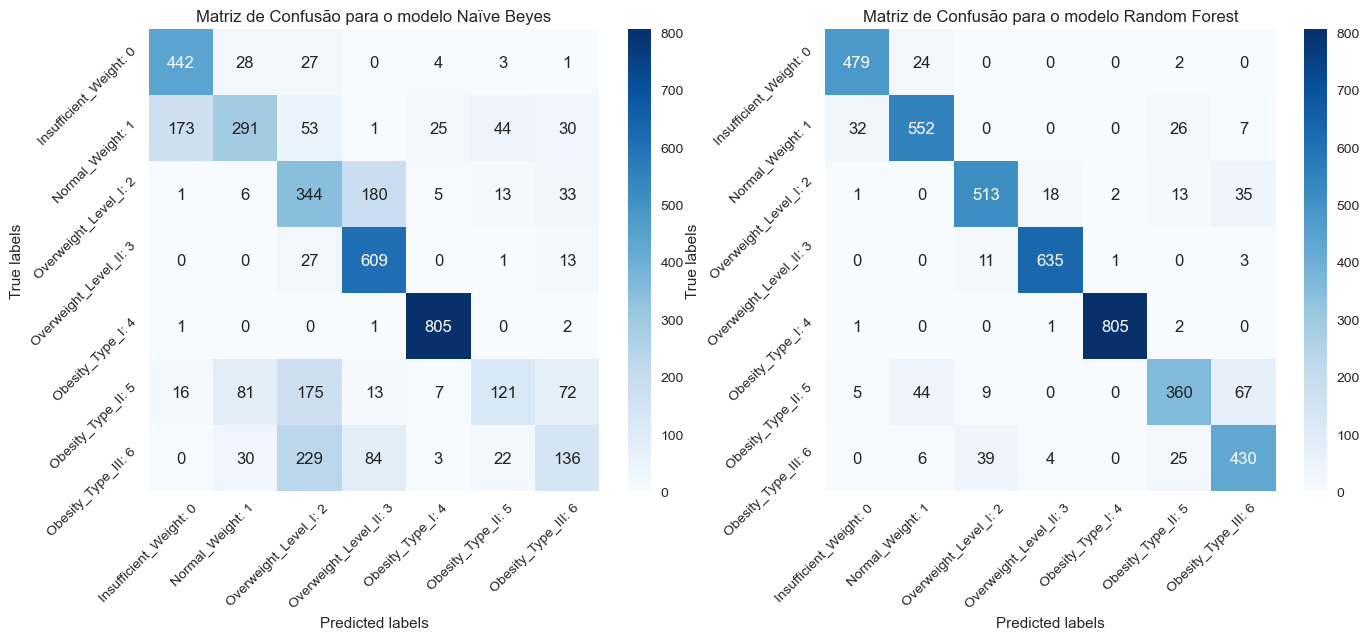

In [155]:
cm_nb = confusion_matrix(y_test, y_predict_naive_bayes)
cm_rf = confusion_matrix(y_test, y_predict_forest)

unique_labels_str = [f'{chave}: {valor}' for chave, valor in mapeamento.items()]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(cm_nb, annot=True, cmap='Blues', fmt='d', ax=axs[0])
axs[0].set_title('Matriz de Confusão para o modelo Naïve Beyes')
axs[0].set_xlabel('Predicted labels')
axs[0].set_ylabel('True labels')
axs[0].set_xticks(range(len(unique_labels_str)))
axs[0].set_xticklabels(unique_labels_str, rotation=45)
axs[0].set_yticks(range(1,len(unique_labels_str)+1))
axs[0].set_yticklabels(unique_labels_str, rotation=45)
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='d', ax=axs[1])
axs[1].set_title('Matriz de Confusão para o modelo Random Forest')
axs[1].set_xlabel('Predicted labels')
axs[1].set_ylabel('True labels')
axs[1].set_xticks(range(len(unique_labels_str)))
axs[1].set_xticklabels(unique_labels_str, rotation=45)
axs[1].set_yticks(range(1,len(unique_labels_str)+1))
axs[1].set_yticklabels(unique_labels_str, rotation=45)

print(f"A acurácia do Naïve Beyes foi de {resultado_naive_bayes}")
print(f"A acurácia do Random Forest foi de {resultado_forest}")
print(f"Diferença {resultado_forest-resultado_naive_bayes}")

Enquanto o Naïve Beyes teve uma acurácia de 66,18%, a Random Forest obteve um resultado de 90,89%, representando uma diferença de 24,71%. Olhando para a matriz de confusão é possível observar que a Random forest teve um resultado superior ao Naïve Beyes em diferenciar as classes 0, 1 e 2, as classes 2 e 3, e também na hora de distinguir as classes 5 e 6 das classes 1, 2 e 3. Ambos tiveram dificuldades em alguns casos de diferenciar as classes 5 e 6 entre si, sendo que no geral a Random Forest teve um desempenho melhor em acertar essas classes.

## Classificação do dataset de teste

Para classificar o dataset de teste foi utilizada uma Random Forest com os mesmos hiperparâmetros obtidos na otimização.

In [47]:
#  {'max_depth': 40, 'max_features': 5, 'min_samples_leaf': 2, 'n_estimators': 900}
random_forest = RandomForestClassifier(max_depth=40, max_features=5, min_samples_leaf=2, n_estimators=900, n_jobs=-1)
random_forest.fit(features,labels) # treinamento do modelo de Random Forest com o dataset de treinamento completo
y_predict_forest = random_forest.predict(test) # classificação com o modelo Random Forest

### Geração do CSV

Por último foi gerado o arquivo .csv para ser enviado ao Kaggle.

In [48]:
mapeamento = {
    0: "Insufficient_Weight",
    1: "Normal_Weight",
    2: "Overweight_Level_I",
    3: "Overweight_Level_II",
    4: "Obesity_Type_I",
    5: "Obesity_Type_II",
    6: "Obesity_Type_III"
}
predict_categorico = [mapeamento[i] for i in y_predict_forest]
resultado = np.column_stack((test_dataset['id'].values, predict_categorico))
np.savetxt('resuldado.csv', resultado, delimiter=',', header="id,NObeyesdad", fmt='%s', comments='')

Na figura abaixo é possível ver o score dado pelo Kaggle para a classificação do dataset de teste.

![Texto Alternativo](Resultados.jpg)